## Import Library

In [1]:
from keras.preprocessing.sequence import pad_sequences
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import glob
import numpy as np
import pandas as pd
import random
import pickle
from spacy.lang.xx import MultiLanguage
nlp = MultiLanguage() #pre-trained model NER
import math

Using TensorFlow backend.


In [2]:
def readline(filename):
    """
        read file
        return
        format [ ['segelas', 'TYPES'], ['douni', 'PRODUCT], ['parfum', 'PRODUCT'], ['collection', 'PRODUCT'], ['fusion', 'PRODUCT']]
    """
    sentences = []
    sentence = []
    with open(filename, encoding='utf-8') as f:
        for i in f:
            if(len(i[:-1]) < 2) or i.startswith("-DOCSTART-"):
                if len(sentence) > 0:
                    sentences.append(sentence)
                    sentence = []
                continue
            splits = i[:-1].split(",")
            sentence.append([splits[0], splits[-1]])
        
        if len(sentence) > 0:
            sentences.append(sentence)
            sentence = []

    return sentences

In [3]:
def createMatrices(sentences, word2Idx, label2Idx, char2Idx):
    """
    Get the matrices for every dataset. Different with normal NER, we do not use casing-features here, because the input 
    from ASR would be case insensitive
        sentences(list) : list of list of words from the input.
        word2Idx(dict)   : Word and its index
        label2Idx(dict)   : Label and its index
        char2Idx(dict)   : Characters and its index
        
    Output:
        dataset(matrix)   :Matrix containing all of the features.
    """
    unknownIdx = word2Idx["UNK"]
    paddingIdx = word2Idx["PAD"]
    
    dataset = []
    
    word_count = 0
    unknown_word_count = 0
    
    for sentence in sentences:
        word_indices = []
        char_indices = []
        label_indices = []
        for word, char, label in sentence:
            word_count += 1
            if word in word2Idx:
                wordIdx = word2Idx[word]
            elif word.lower() in word2Idx:
                wordIdx = word2Idx[word.lower()]
            else:
                wordIdx = unknownIdx
                unknown_word_count += 1
            
            charIdx = []
            for x in char:
                try:
                    charIdx.append(char2Idx[x])
                except KeyError:
                    charIdx.append(char2Idx["UNK"])
            
            word_indices.append(wordIdx)
            char_indices.append(charIdx)
            label_indices.append(label2Idx[label])
            
        dataset.append([word_indices, char_indices, label_indices])
    
    return dataset

In [4]:
def addCharInformation(sentences):
    """
    Split the word in the sentences from 1 dataset into list of characters:
        ex: [["S","e","l","a","m","a","t"],["P","a","g","i"]]
    Input:
        sentences(list)   : The dataset
    """    
    for i, sentence in enumerate(sentences):
        for j, data in enumerate(sentence):
            chars = [i for i in data[0]]
            sentences[i][j] = [data[0], chars, data[1]] ## data[0] is token, chars is chars of token, data[1] is label/entity
    return sentences

In [5]:
def padding(sentences):
    """
    Because the batches already with same length, we are not padding it anymore. We padding the characters instead
        ex: [["S","e","l","a","m","a","t"],["P","a","g","i","<PAD>","<PAD>","<PAD>"]]
        
    Input:
        sentence(list)   :The dataset
    """
    
    maxwordlength = 15 #15 character max in 1 word
    for i,sentence in enumerate(sentences):
        sentences[i][1] = pad_sequences(sentences[i][1], maxwordlength, padding='pre',truncating='post')
    return sentences

In [6]:
def createBatches(data):
    """
    Create the batches for train_on_batch keras.
    Input:
        data(list)   :The dataset
    """
    l = []
    for i in data:
        l.append(len(i[0]))
    l = set(l)  ## kata
    batches = []
    batch_len = []
    z = 0
    
    for i in l:
        for batch in data:
            if(len(batch[0]) == i):
                batches.append(batch)
                z+=1
        batch_len.append(z)
    return batches, batch_len

In [7]:
def iterate_minibatches(dataset,batch_len):
    """
    Generator for dataset to be yielded during training
    Input:
        Dataset(list) : The dataset
        batch_len(list) :Start and end batch_len
    Output:
        Array of [labels, tokens, casing, char] features
    """
    while True:
        start = 0
        for i in batch_len:
            tokens = []
            char = []
            labels = []
            data = dataset[start:i]
            start = i
            for dt in data:
                t,ch,l = dt
                l = np.expand_dims(l, -1)
                tokens.append(t)
                char.append(ch)
                labels.append(l)
            feature = [np.asarray(tokens),np.asarray(char)]
            yield feature, np.asarray(labels)

In [8]:
## Predict data
def tag_dataset(dataset):
    correctLabels = []
    predLabels = []
    b = Progbar(len(dataset))
    for i, data in enumerate(dataset):
        tokens, char, labels = data
        tokens = np.asarray([tokens])
        char = np.asarray([char])
        
        pred = model.predict([tokens, char], verbose = False)[0]
        pred = pred.argmax(axis = -1) #Predict the classes
        correctLabels.append(labels)
        predLabels.append(pred)
        b.update(i)
    b.update(i+1)
    
    return predLabels, correctLabels

# 1. Open the file needed and Convert the word into list of chars

In [9]:
trainSentences = readline("../data/clean/dataset.csv")
trainSentences = addCharInformation(trainSentences)

testSentences = readline("../data/clean/test.csv")
testSentences = addCharInformation(testSentences)

# 2. Get the Label from the dataset, and convert it to index

In [10]:
label_set = set()
words = {}
for sentence in trainSentences:
    for token, char, label in sentence:
        label_set.add(label)
        words[token.lower()] = True

label2idx = {v:k for k,v in enumerate(sorted(label_set))}
idx2label = {v:k for k,v in label2idx.items()}

# 3. Mittens Word Embedding (Extensions for GloVe model). Its retrofitting model

In [11]:
## Load word2idx pickle
pickle_word2idx_glove = open("../data/pickle_file/word2idx_glove.pkl","rb")
word2idx_glove = pickle.load(pickle_word2idx_glove)
word2Idx = {i[0]:i[1] for i in word2idx_glove}

## Load mittens embedding
embedding_file_path = '../model/mittens_embedding.pkl'
wordEmbeddings = pickle.load(open(embedding_file_path, "rb"))

In [12]:
## n-dimensional vector of word embeddings
n_dim = wordEmbeddings.shape[1]

word2Idx.update({'PAD': len(word2Idx)})
wordEmbeddings = np.concatenate((wordEmbeddings, np.zeros((1, n_dim))))
word2Idx.update({'UNK': len(word2Idx)})
wordEmbeddings = np.concatenate((wordEmbeddings, np.random.uniform(-0.25*10**-3, 0.25*10**-3,n_dim).reshape((1,n_dim))))

# 4. Get list of characters and its index

In [13]:
char2Idx = {"PAD":0, "UNK":1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|":
    char2Idx[c] = len(char2Idx)

# 5. Create Dataset

In [14]:
train_set = createMatrices(trainSentences, 
               word2Idx = word2Idx, 
               label2Idx = label2idx,
               char2Idx = char2Idx)

test_set = createMatrices(testSentences, 
               word2Idx = word2Idx, 
               label2Idx = label2idx,
               char2Idx = char2Idx)

In [15]:
train_set = padding(train_set)
test_set = padding(test_set)

In [16]:
X_train, X_test = train_test_split(train_set, train_size = 0.75, random_state=42, shuffle=True)
X_val, X_test = train_test_split(X_test, train_size= 0.5, random_state=42, shuffle=True)

In [17]:
train_batch, train_batch_len = createBatches(X_train)
val_batch, val_batch_len = createBatches(X_val)
test_batch, test_batch_len = createBatches(X_test)
real_test_batch, real_test_batch_len = createBatches(test_set)

In [18]:
print(train_batch_len)
print(val_batch_len)
print(test_batch_len)
print(real_test_batch_len)

[553, 56916, 168505, 305244, 430514, 501430, 557167, 568741, 572517, 575337]
[107, 9581, 28194, 51000, 72005, 83810, 92874, 94765, 95435, 95890]
[82, 9245, 27815, 50906, 71750, 83610, 92845, 94755, 95393, 95890]
[156, 3634, 22854, 55564, 83042, 101962, 121306, 127466]


In [19]:
batch_size = 256
train_batch_size = []
val_batch_size = []
test_batch_size = []
real_test_batch_size = []

## Change training batch size
for val in range(batch_size, max(train_batch_len), batch_size):
    train_batch_size.append(val)
for val in train_batch_len:
    train_batch_size.append(val)
    
train_batch_size.sort()

## Change validation batch size
for val in range(batch_size, max(val_batch_len), batch_size):
    val_batch_size.append(val)
for val in val_batch_len:
    val_batch_size.append(val)
    
val_batch_size.sort()

## Change testing batch size
for val in range(batch_size, max(test_batch_len), batch_size):
    test_batch_size.append(val)
for val in test_batch_len:
    test_batch_size.append(val)

test_batch_size.sort()

## Change real testing batch size
for val in range(batch_size, max(real_test_batch_len), batch_size):
    real_test_batch_size.append(val)
for val in real_test_batch_len:
    real_test_batch_size.append(val)

real_test_batch_size.sort()

# Model

In [20]:
from keras.layers import Input, Embedding, Dropout, TimeDistributed, Conv1D, Dense, multiply, CuDNNLSTM, GlobalAveragePooling1D
from keras.layers import Concatenate, MaxPooling1D, GlobalMaxPooling1D, Flatten, Bidirectional, LSTM, ThresholdedReLU
from keras.initializers import RandomUniform
from keras.models import Model, load_model
from keras.utils import plot_model,Progbar
from keras.callbacks import EarlyStopping
from keras_multi_head import MultiHeadAttention
from keras import optimizers

In [21]:
maxwordlength = 15
dropout_p = 0.5
char_embedding_dim = 30

In [22]:
def get_word_embed(wordEmbeddings):
    ## Input Layer
    words_input = Input(shape = (None,), dtype = np.int32, name = 'words_input')
    ## Embedding Layer
    words = Embedding(input_dim = wordEmbeddings.shape[0],
                      output_dim = wordEmbeddings.shape[1],
                      weights = [wordEmbeddings],
                      trainable = False)(words_input)
    return words_input, words

In [23]:
def get_char_embed(maxwordlength, char2Idx, char_embedding_dim):
    ## Input Layer
    chars_input = Input(shape = (None, maxwordlength, ), name = 'chars_input')
    ## Embedding Layer
    chars = TimeDistributed(Embedding(input_dim = len(char2Idx),
                  output_dim = char_embedding_dim,
                  embeddings_initializer = RandomUniform(minval=-0.5, maxval=0.5)))(chars_input)
    return chars_input, chars

In [24]:
def get_model(dropout_p, chars, words):
    ## Convolution layer
    conv = TimeDistributed(Dropout(dropout_p))(chars)
    conv = TimeDistributed(Conv1D(filters = 30,
                                  kernel_size = 3,
                                  padding = 'same',
                                  activation = 'tanh',
                                  strides = 1))(conv)
    conv = TimeDistributed(MaxPooling1D(maxwordlength))(conv)
    ## Flatten
    conv = TimeDistributed(Flatten())(conv)
    chars = TimeDistributed(Dropout(dropout_p))(conv)
    ## Concatenate words embed and char-representation
    output = Concatenate()([words, chars])
    ## Bi-LSTM
    output = Bidirectional(CuDNNLSTM(200, kernel_initializer='random_uniform',
                           bias_initializer='zeros', return_sequences = True))(output)
    ## Dropout
    output = Dropout(dropout_p)(output)
    ## MultiHeadAttention
    attn = MultiHeadAttention(head_num=400, name = 'Multi-head')(output)
    ## LSTM
    output = CuDNNLSTM(200, kernel_initializer='random_uniform',
             bias_initializer='zeros', return_sequences = True)(attn)
    ## Dropout
    output = Dropout(dropout_p)(output)
    ## CRF
    crf = CRF(len(label2idx), sparse_target=True)
    output = crf(output)
    
    return output

In [25]:
words_input, words = get_word_embed(wordEmbeddings)
chars_input, chars = get_char_embed(maxwordlength, char2Idx, char_embedding_dim)
output = get_model(dropout_p, chars, words)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [26]:
## Optimizer
nadam = optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model = Model(inputs = [words_input, chars_input], outputs = [output])
model.compile(loss = crf_loss, optimizer = nadam, metrics=[crf_accuracy])
print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
chars_input (InputLayer)        (None, None, 15)     0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 15, 30) 2850        chars_input[0][0]                
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, None, 15, 30) 0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, None, 15, 30) 2730        time_distributed_2[0][0]        

# Training Process

In [27]:
## Generator
train_generator = iterate_minibatches(train_batch, train_batch_size)
val_generator = iterate_minibatches(val_batch, val_batch_size)
test_generator = iterate_minibatches(real_test_batch, real_test_batch_size)

early_stopping_callback = EarlyStopping(monitor='val_crf_accuracy', mode='max', verbose=1, patience=10)
epochs = 50
history = model.fit_generator(train_generator, steps_per_epoch=len(train_batch_size), epochs=epochs,
                    callbacks=[early_stopping_callback],
                    validation_data=test_generator, validation_steps=len(real_test_batch_size))


Epoch 1/50
2257/2257 [==============================] - 244s 108ms/step - loss: -0.1540 - crf_accuracy: 0.9783 - val_loss: -0.1527 - val_crf_accuracy: 0.9316
Epoch 2/50
2257/2257 [==============================] - 225s 100ms/step - loss: -0.6134 - crf_accuracy: 0.9968 - val_loss: -0.3383 - val_crf_accuracy: 0.9317
Epoch 3/50
2257/2257 [==============================] - 226s 100ms/step - loss: -1.0332 - crf_accuracy: 0.9981 - val_loss: -0.3128 - val_crf_accuracy: 0.9297
Epoch 4/50
2257/2257 [==============================] - 225s 100ms/step - loss: -1.4517 - crf_accuracy: 0.9985 - val_loss: -0.5739 - val_crf_accuracy: 0.9289
Epoch 5/50
2257/2257 [==============================] - 224s 99ms/step - loss: -1.8692 - crf_accuracy: 0.9988 - val_loss: -0.5933 - val_crf_accuracy: 0.9228
Epoch 6/50
2257/2257 [==============================] - 224s 99ms/step - loss: -2.2854 - crf_accuracy: 0.9988 - val_loss: -0.7924 - val_crf_accuracy: 0.9320
Epoch 7/50
2257/2257 [==============================]

In [28]:
model.save("../model/ner_warung.h5")

## Plot model accuracy and loss

dict_keys(['val_loss', 'val_crf_accuracy', 'loss', 'crf_accuracy'])


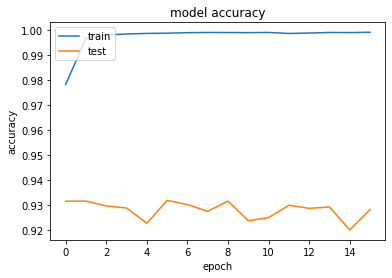

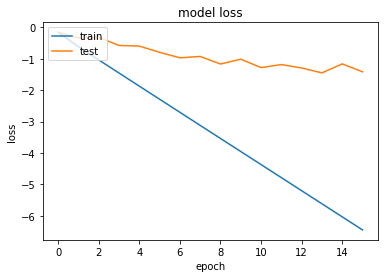

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['crf_accuracy'])
plt.plot(history.history['val_crf_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
import pickle
pickle.dump(word2Idx,open("../data/pickle_file/word2idx.pkl", "wb"))
pickle.dump(char2Idx, open("../data/pickle_file/char2idx.pkl","wb"))
pickle.dump(label2idx, open("../data/pickle_file/label2idx.pkl","wb"))

In [31]:
model = load_model("../model/ner_warung.h5",
                   custom_objects ={'CRF':CRF,
                                   'crf_loss':crf_loss,
                                   'crf_accuracy':crf_accuracy,
                                   'MultiHeadAttention':MultiHeadAttention})

In [32]:
def checkaccuracy(predict_label,correct_label):
    count = 0
    for i in zip(predict_label, correct_label):
        if(i[0] != i[1]):
            count += 1
    if(count == 0):
        return 1
    else:
        return 0

In [33]:
# Performance on dev dataset
predLabels, correctLabels = tag_dataset(test_batch)

# Calculate Performance of model on data
counter = 0
for i in range(len(predLabels)):
    counter += checkaccuracy(predLabels[i], correctLabels[i])
print("Accuracy:", counter/len(predLabels))

95890/95890 [==============================] - 783s 8ms/step
Accuracy: 0.9967045573052455


# Fine Tuning using Bayesian Optimization

In [34]:
def fit_with(verbose, wordEmbeddings, maxwordlength, char2Idx, char_embedding_dim, train_generator, 
             train_batch_size, test_generator, real_test_batch_size, dropout_p, lr):
    
    # Create the embedding
    words_input, words = get_word_embed(wordEmbeddings)
    chars_input, chars = get_char_embed(maxwordlength, char2Idx, char_embedding_dim)
    
    # Create the model using a specified hyperparameters.
    model = get_model(dropout_p, chars, words)

    # Train the model for a specified number of epochs.
    optimizer = optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
    model = Model(inputs = [words_input, chars_input], outputs = [model])
    model.compile(loss = crf_loss, optimizer = optimizer, metrics=[crf_accuracy])

    # Train the model with the train dataset.
    print('Starting--')
    epochs = 10
    model.fit_generator(train_generator, steps_per_epoch=len(train_batch_size), epochs=epochs)

    # Evaluate the model with the test dataset.
    score = model.evaluate_generator(test_generator, steps=len(real_test_batch_size))
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # Return the accuracy.
    return score[1]

In [35]:
from functools import partial

verbose = 1
fit_with_partial = partial(fit_with, verbose, wordEmbeddings, maxwordlength, char2Idx,
                           char_embedding_dim, train_generator,train_batch_size, test_generator,
                           real_test_batch_size)

In [36]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

# Bounded region of parameter space
pbounds = {'dropout_p': (0.35, 0.7), 'lr': (0.001, 0.01)}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2,
    random_state=42,
)

logger = JSONLogger(path="../model/logs.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
optimizer.maximize(init_points=3, n_iter=50)

# New optimizer is loaded with previously seen points
load_logs(optimizer, logs=["../model/logs.json"])

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print("Result Fine Tuning : ", optimizer.max)

Starting--
Epoch 1/10
2257/2257 [==============================] - 206s 91ms/step - loss: -2.1069 - crf_accuracy: 0.9582
Epoch 2/10
2257/2257 [==============================] - 212s 94ms/step - loss: -5.9491 - crf_accuracy: 0.9184
Epoch 3/10
2257/2257 [==============================] - 213s 94ms/step - loss: -9.8961 - crf_accuracy: 0.8510
Epoch 4/10
2257/2257 [==============================] - 214s 95ms/step - loss: -13.8383 - crf_accuracy: 0.8248
Epoch 5/10
2257/2257 [==============================] - 217s 96ms/step - loss: -17.7596 - crf_accuracy: 0.8109
Epoch 6/10
2257/2257 [==============================] - 217s 96ms/step - loss: -21.7415 - crf_accuracy: 0.7938
Epoch 7/10
2257/2257 [==============================] - 216s 96ms/step - loss: -25.7547 - crf_accuracy: 0.7989
Epoch 8/10
2257/2257 [==============================] - 217s 96ms/step - loss: -29.6334 - crf_accuracy: 0.7714
Epoch 9/10
2257/2257 [==============================] - 217s 96ms/step - loss: -33.6046 - crf_accuracy: 

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7eff13ca7a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py", line 1481, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: 